# Instalar Paquetes faltantes

In [ ]:
%pip install -r requirements.txt

In [ ]:
%pip install 

In [187]:
# Generar ambiente
%pip freeze >> requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Importar Paquetes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date, datetime
import matplotlib.pyplot as plt
import holidays
import sklearn, sklearn.model_selection, sklearn.impute
from sklearn import tree
import scipy
import shap
from pathlib import Path
pd.options.display.float_format = '{:,.2f}'.format
seed = 1026252241

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
import tensorflow as tf
import sklearn.decomposition
from sklearn.cluster import k_means
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

c:\Users\NicolasSG\Downloads\MeliChallenge\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TF version: 2.10.1
TFP version: 0.18.0


# Cargue de Datos

El objetivo de esta sección es cargar los datos y separarlos por tipo de columna para poder hacer un análisis más adecuado de éstos

In [2]:
dataset = pd.read_csv('Dataset.csv')
# vamos a transformar la columna 'fecha' en una columna temporal para poder hacer un mejor análisis.
dataset['fecha'] = dataset['fecha'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S' ))
# creamos paquetes de columnas por tipo para análisis posterior.
str_columns = ['g','j', 'o','p']
int_columns  = ['a','h', 'n','score', 'fraude']
float_columns = ['b','c','d','e','f','k','l','m','monto']
dt_columns = ['fecha']
numeric_columns = float_columns + int_columns


# Analisis preeliminar de las variables y relación con el Fraude

## Tablas descriptivas

In [30]:
dataset[str_columns].describe()

,g,j,o,p
count,149806,150000,41143,150000
unique,51,8324,2,2
top,BR,cat_43b9c10,Y,Y
freq,111628,2331,24091,83129


In [31]:
dataset[int_columns].describe()

,a,h,n,score,fraude
count,"150,000.00","150,000.00","150,000.00","150,000.00","150,000.00"
mean,3.71,14.19,0.90,48.07,0.05
std,0.75,14.16,0.30,29.00,0.22
min,1.00,0.00,0.00,0.00,0.00
25%,4.00,3.00,1.00,23.00,0.00
50%,4.00,9.00,1.00,48.00,0.00
75%,4.00,21.00,1.00,73.00,0.00
max,4.00,58.00,1.00,100.00,1.00


In [32]:
dataset[float_columns].describe()

,b,c,d,e,f,k,l,m,monto
count,"137,016.00","137,016.00","149,635.00","150,000.00","149,989.00","150,000.00","149,989.00","149,635.00","150,000.00"
mean,0.73,"260,445.11",21.68,0.22,51.17,0.50,"2,305.41",299.97,43.52
std,0.13,"846,436.14",20.06,2.43,709.47,0.29,"1,712.38",321.08,91.56
min,0.00,0.16,0.00,0.00,-5.00,0.00,0.00,0.00,0.02
25%,0.68,"9,679.91",2.00,0.00,1.00,0.25,910.00,42.00,9.38
50%,0.76,"43,711.65",14.00,0.10,8.00,0.50,"1,937.00",193.00,20.61
75%,0.81,"145,443.63",50.00,0.28,33.00,0.75,"3,445.00",459.00,40.69
max,1.00,"13,878,743.71",50.00,833.33,"145,274.00",1.00,"7,544.00","2,225.00","3,696.35"


<Axes: >

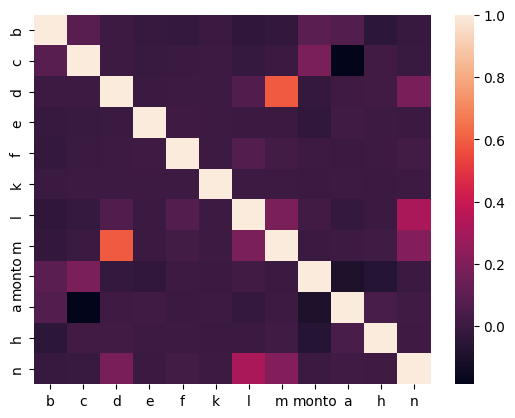

In [33]:
sns.heatmap(dataset[numeric_columns[:-2]].corr())

In [34]:
dataset[dt_columns].describe()

,fecha
count,150000
mean,2020-03-30 23:41:40.546253312
min,2020-03-08 00:02:15
25%,2020-03-18 12:40:32.249999872
50%,2020-03-31 00:08:33
75%,2020-04-12 12:40:16
max,2020-04-21 23:59:56


## revisión de dónde hay N/As 

In [35]:
dataset[numeric_columns].isna().sum()

b         12984
c         12984
d           365
e             0
f            11
k             0
l            11
m           365
monto         0
a             0
h             0
n             0
score         0
fraude        0
dtype: int64

In [36]:
na_d_y_m = dataset[dataset['d'].isna()]['m'].isna().sum() == dataset['d'].isna().sum()
na_b_y_c = dataset[dataset['b'].isna()]['c'].isna().sum() == dataset['b'].isna().sum()
na_f_y_l = dataset[dataset['f'].isna()]['l'].isna().sum() == dataset['f'].isna().sum()
print(f'{na_d_y_m}, {na_b_y_c},  {na_f_y_l}')

True, True,  True


In [37]:
dataset[str_columns].isna().sum()

g       194
j         0
o    108857
p         0
dtype: int64

## Algunas gráficas

El objetivo de la presente sección es dar más intuición sobre las distribuciones de cada uno de los tipos de columnas, su relación con el fraude, y las posibles transformaciones y formas de rellenar N/As

<Axes: xlabel='m', ylabel='Count'>

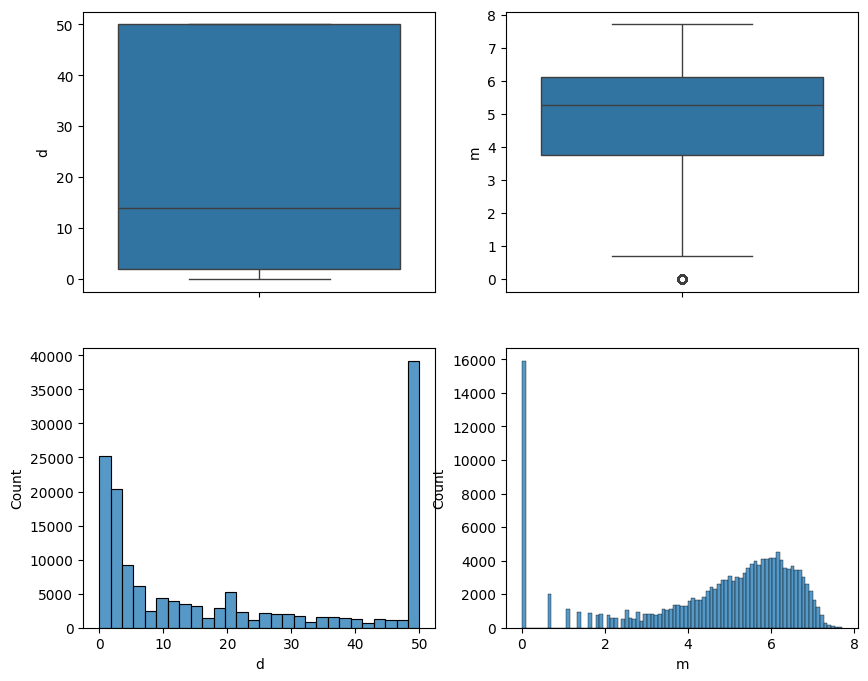

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.boxplot(dataset['d'], ax=axes[0,0])
sns.boxplot(np.log1p(dataset['m']), ax=axes[0,1])
sns.histplot(dataset['d'], ax=axes[1,0])
sns.histplot(np.log1p(dataset['m']), ax=axes[1,1])


<Axes: xlabel='c', ylabel='Count'>

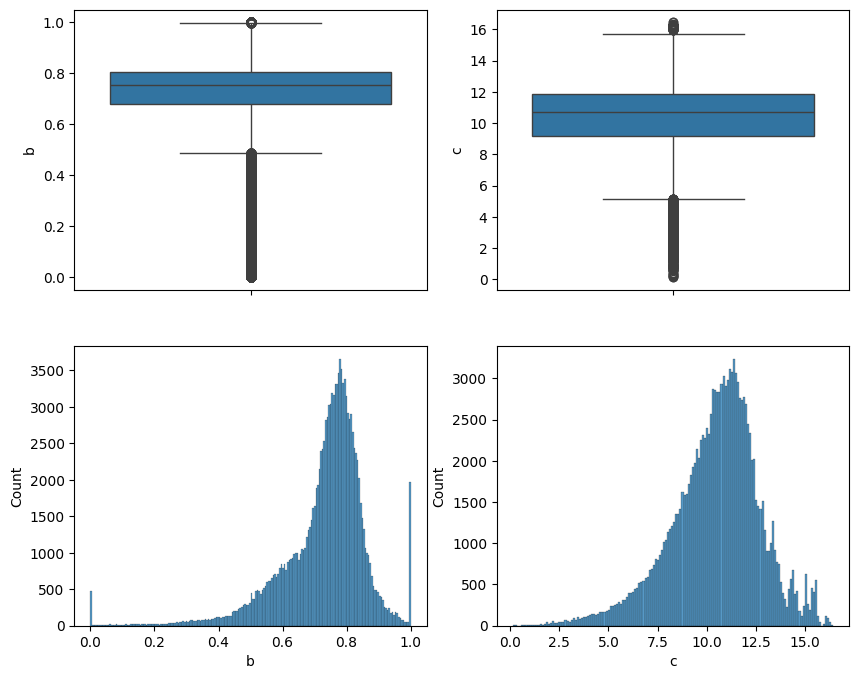

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.boxplot(dataset['b'], ax=axes[0,0])
sns.boxplot(np.log1p(dataset['c']), ax=axes[0,1])
sns.histplot(dataset['b'], ax=axes[1,0])
sns.histplot(np.log1p(dataset['c']), ax=axes[1,1])

<Axes: xlabel='f', ylabel='Count'>

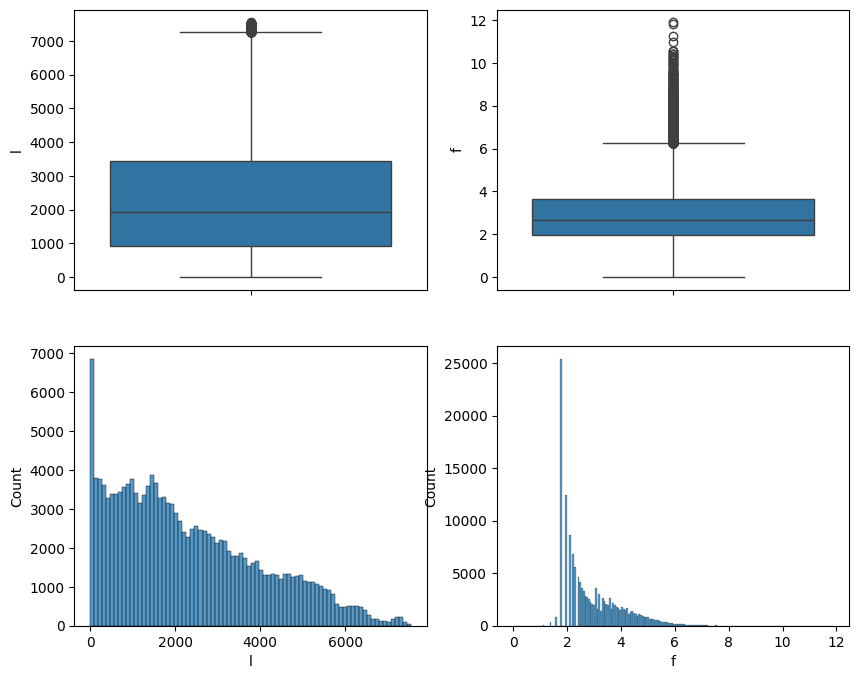

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.boxplot(dataset['l'], ax=axes[0,0])
sns.boxplot(np.log1p(dataset['f']+5), ax=axes[0,1])
sns.histplot(dataset['l'], ax=axes[1,0])
sns.histplot(np.log1p(dataset['f']+5), ax=axes[1,1])

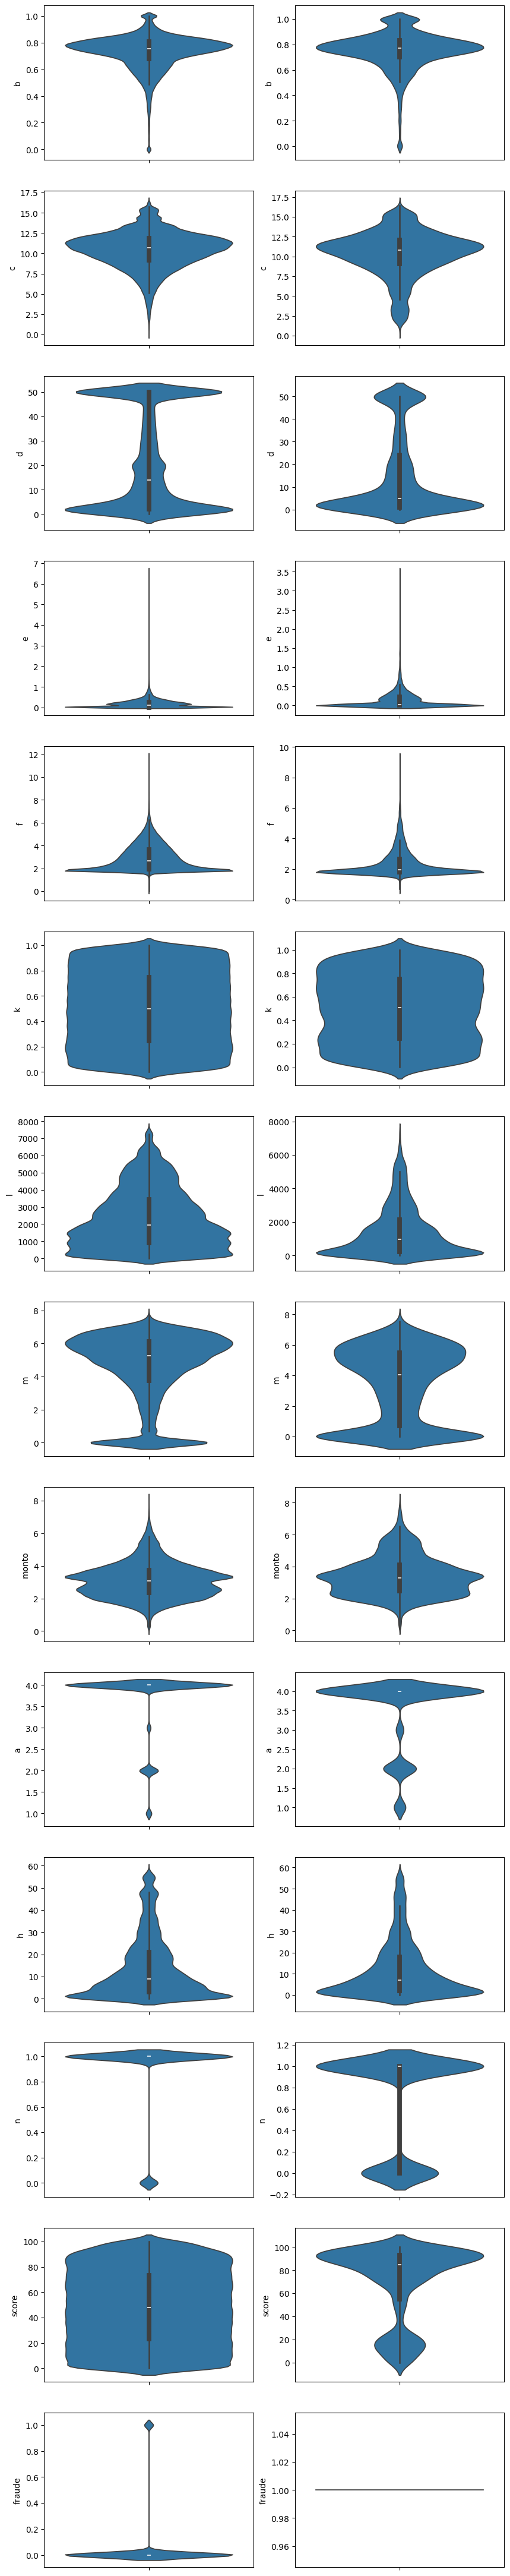

In [41]:

fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(10,len(numeric_columns) *4))
fraude_filter = dataset['fraude']==1
log_columns = {'c','e','f','m','monto'}
for col in numeric_columns:   
    idx = numeric_columns.index(col)
    not_na_filter = dataset[col].isna().apply(lambda l: not l)
    
    if col in log_columns:
        min_col = dataset[col].min()-1
        sns.violinplot(np.log( dataset[not_na_filter][col]-min_col), ax =axes[idx,0])
        sns.violinplot(np.log( dataset[(not_na_filter) & (fraude_filter)][col]-min_col),
                        ax =axes[idx,1])
    else:
        sns.violinplot(dataset[not_na_filter][col], ax =axes[idx,0])
        sns.violinplot(dataset[(not_na_filter) & (fraude_filter)][col], ax =axes[idx,1])

<Axes: ylabel='e'>

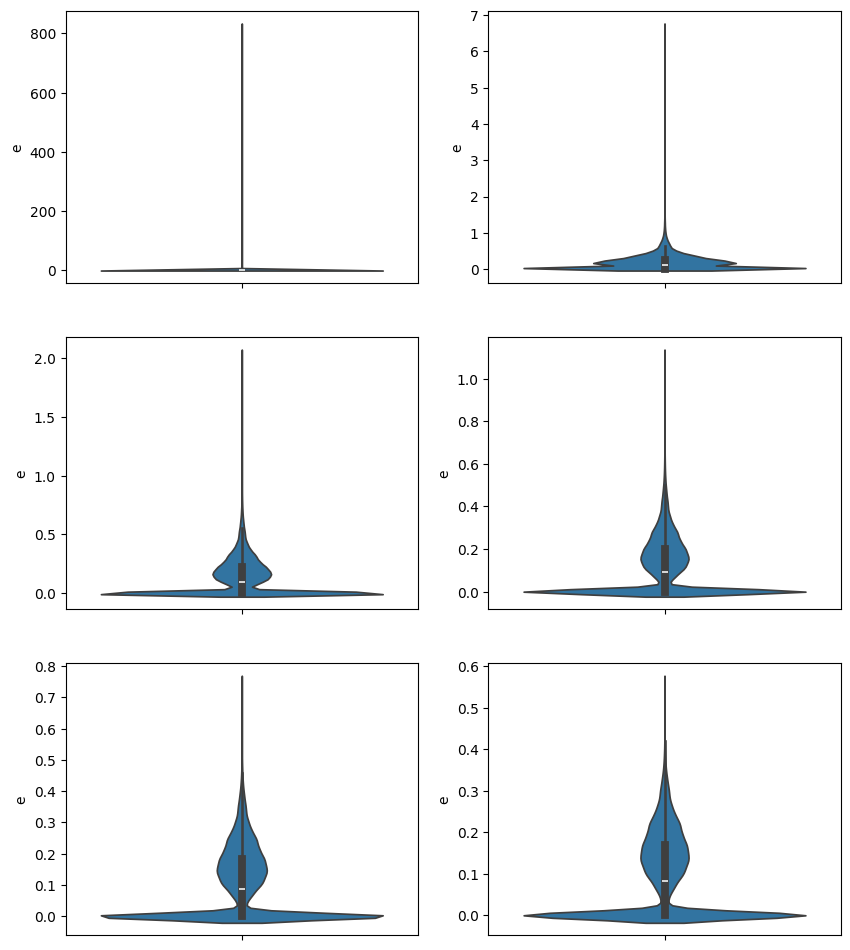

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(10,12))
sns.violinplot(dataset['e'], ax= axes[0,0])
sns.violinplot(np.log1p(dataset['e']), ax= axes[0,1])
sns.violinplot(np.log1p(np.log1p(dataset['e'])), ax= axes[1,0])
sns.violinplot(np.log1p(np.log1p(np.log1p(dataset['e']))), ax= axes[1,1])
sns.violinplot(np.log1p(np.log1p(np.log1p(np.log1p(dataset['e'])))), ax= axes[2,0])
sns.violinplot(np.log1p(np.log1p(np.log1p(np.log1p(np.log1p(dataset['e']))))), ax= axes[2,1])

<Axes: ylabel='e'>

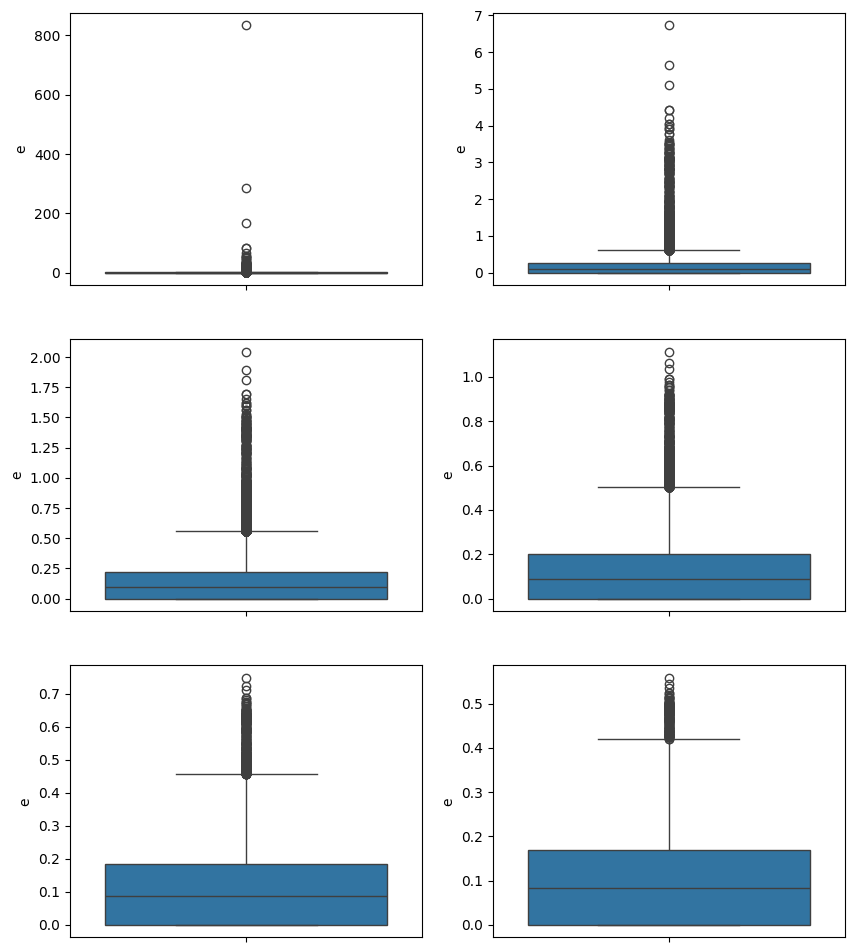

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(10,12))
sns.boxplot(dataset['e'], ax= axes[0,0])
sns.boxplot(np.log1p(dataset['e']), ax= axes[0,1])
sns.boxplot(np.log1p(np.log1p(dataset['e'])), ax= axes[1,0])
sns.boxplot(np.log1p(np.log1p(np.log1p(dataset['e']))), ax= axes[1,1])
sns.boxplot(np.log1p(np.log1p(np.log1p(np.log1p(dataset['e'])))), ax= axes[2,0])
sns.boxplot(np.log1p(np.log1p(np.log1p(np.log1p(np.log1p(dataset['e']))))), ax= axes[2,1])

<Axes: xlabel='e', ylabel='Count'>

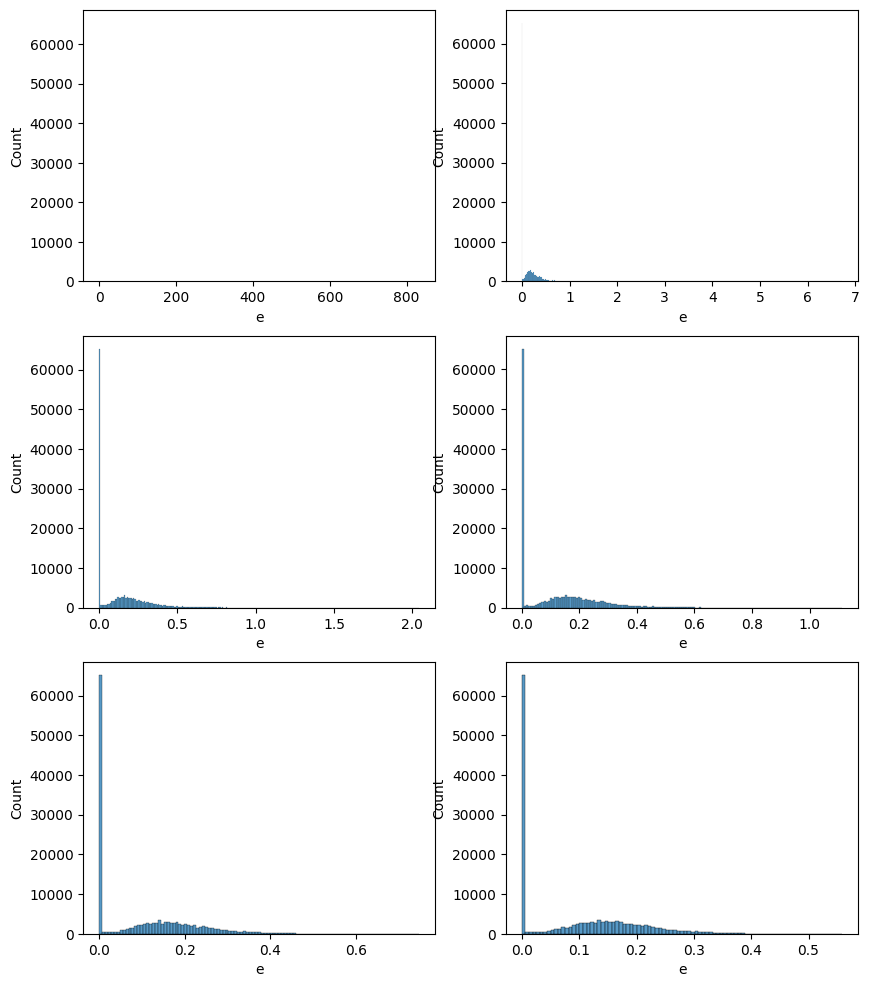

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(10,12))
sns.histplot(dataset['e'], ax= axes[0,0])
sns.histplot(np.log1p(dataset['e']), ax= axes[0,1])
sns.histplot(np.log1p(np.log1p(dataset['e'])), ax= axes[1,0])
sns.histplot(np.log1p(np.log1p(np.log1p(dataset['e']))), ax= axes[1,1])
sns.histplot(np.log1p(np.log1p(np.log1p(np.log1p(dataset['e'])))), ax= axes[2,0])
sns.histplot(np.log1p(np.log1p(np.log1p(np.log1p(np.log1p(dataset['e']))))), ax= axes[2,1])

<Axes: xlabel='fecha', ylabel='Count'>

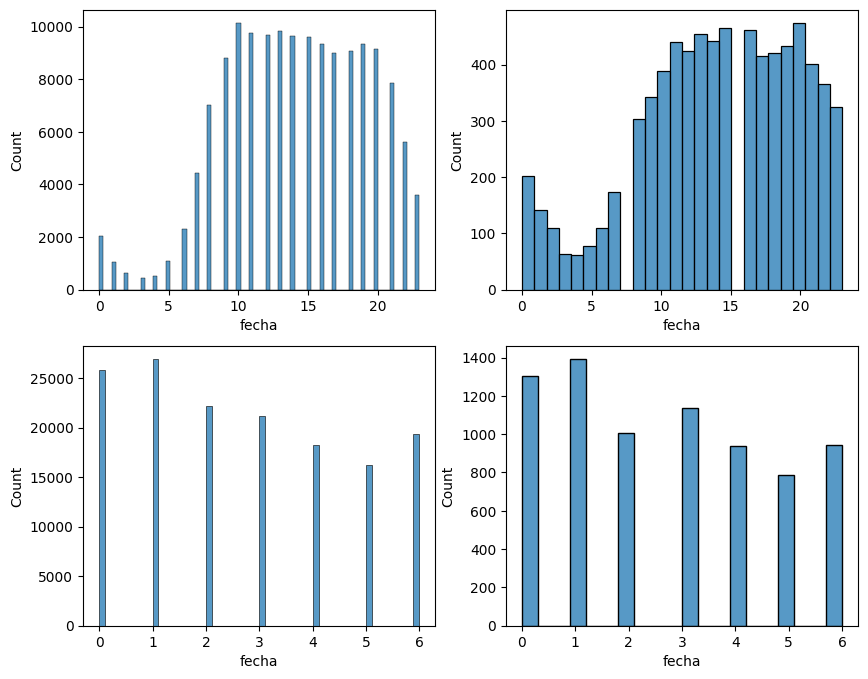

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.histplot(dataset['fecha'].dt.hour, ax= axes[0,0])
sns.histplot(dataset['fecha'].dt.day_of_week, ax= axes[1,0])
sns.histplot(dataset[dataset['fraude']==1]['fecha'].dt.hour,  ax= axes[0,1])
sns.histplot(dataset[dataset['fraude']==1]['fecha'].dt.day_of_week, ax= axes[1,1])

In [46]:
def es_festivo_en_ese_pais(fecha_obj: date, cod_pais:str)-> int:
    """Determina si una fecha es un festivo para un país.

    :param fecha_obj: Fecha que queremos verificar si es festivo o no.
    :type fecha_obj: date
    :param cod_pais: Código de dos caracteres que representa el país
    :type cod_pais: str
    :return: 1 si es festivo 0 si no, o no encuentra el país
    :rtype: int
    """
    
    try:
         return 1*(fecha_obj in holidays.country_holidays(cod_pais))
    except (NotImplementedError,TypeError):
        return 0
def agregar_coluna_festivo(row:pd.Series)-> pd.Series:
    """a un dataset que en la columna g tenga el código de un país, y en la columna fecha
    agrega una columna de nombre es_dia_descanso si es festivo con respecto a la salida de
    es_festivo_en_ese_pais o si la fecha es 5 - sábado o 6 - domingo

    :param row: fila a transformar
    :type row: pd.Series
    :return: fila con la columna agregada
    :rtype: pd.Series
    """
    es_fin_de_semana = 1*(row['fecha'].day_of_week>= 5)
    es_festivo = es_festivo_en_ese_pais(row['fecha'].date(), row['g'])
    row['es_dia_descanso'] = max(es_fin_de_semana,es_festivo)
    return row


# Preparación para entrenamiento

Vamos a separar el 90% para entrenamiento, 5% para "early stop" y 5% para validación. 
Además queremos que en los tres conjuntos haya la misma proporción de fraudes para efectos de la evaluación.

In [3]:
dataset_f = dataset[dataset['fraude']==1].copy()
dataset_b = dataset[dataset['fraude']==0].copy()
times_b_over_f = len(dataset_b) // len(dataset_f)
train_ds_f, dev_test_ds_f = sklearn.model_selection.train_test_split(dataset_f, train_size= 0.9,  random_state=seed, shuffle=True)
dev_ds_f, test_ds_f = sklearn.model_selection.train_test_split(dev_test_ds_f, train_size= 0.5,  random_state=seed, shuffle=True)
train_ds_b, dev_test_ds_b = sklearn.model_selection.train_test_split(dataset_b, train_size= 0.9,  random_state=seed, shuffle=True)
dev_ds_b, test_ds_b = sklearn.model_selection.train_test_split(dev_test_ds_b, train_size= 0.5,  random_state=seed, shuffle=True)

train_ds = pd.concat([train_ds_f for _ in range(times_b_over_f)] +[train_ds_b], axis = 0, ignore_index = True).sample(frac= 1, random_state= seed)
test_ds = pd.concat([test_ds_f, test_ds_b], axis = 0, ignore_index = True).sample(frac= 1, random_state= seed)
dev_ds = pd.concat([dev_ds_f, dev_ds_b], axis = 0, ignore_index = True).sample(frac= 1, random_state= seed)


19

In [4]:
const_c_bar =(np.log1p( train_ds['c']) ).mean() 
def prepare_data(df:pd.DataFrame)->pd.DataFrame:
    """Esta función regulariza y trasforma un DataFrame dejando en las dos primeras columnas
    las variables que seguirán siendo categoricas, y en la última columna la que ha de ser
    predicha. Las transformaciones están basadas en los análisis hechos en la sección anterior
    

    :param df: Dataframe de entrada
    :type df: pd.DataFrame
    :return: Dataframe de salida
    :rtype: pd.DataFrame
    """
    hora = df['fecha'].dt.hour/23
    hora.name = 'hora'
    dia_sem = df['fecha'].dt.day_of_week/6
    dia_sem.name = 'dia_sem'
    return pd.concat([
        df['g'].fillna('UNK'),#paises
        df['j'],#producto
        df['a']/4,
        df['b'],
        np.log1p(df['c'])/const_c_bar,
        df['d']/50,
        np.log1p(df['e']).apply(lambda l: min(1,l)),
        np.log1p(df['f']+5),
        df['h']/60,
        df['k'],
        df['l']/7000,
        np.log1p(df['m'])/np.log(2000),
        df['n'],
        1*(df['o']=='Y') +  0*(df['o']=='N') - 1* (df['o'].isna()),
        1*(df['p']=='Y'),
        np.log1p(df['monto'])/np.log(3000),
        hora,
        dia_sem,
        df['fraude']#Y

    ]
    , axis = 1)
def get_imputer(df:pd.DataFrame, n_neighbors=5)->sklearn.impute.KNNImputer :
    """Crea el imputador a partir de K - vecinos más cercanos

    :param df: dataframe sobre el que se van a imputar todos los datos, debe ser númerico
    :type df: pd.DataFrame
    :return: el imputador
    :rtype: sklearn.impute.KNNImputer
    """
    imp = sklearn.impute.KNNImputer(n_neighbors = n_neighbors)
    return imp.fit(df)
def fill_data(df:pd.DataFrame, imputer: sklearn.impute.KNNImputer)->pd.DataFrame:
    """_summary_

    :param df: Data frame para entrenar el imputer, todos los campos son númericos
    :type df: pd.DataFrame
    :param imputer: imputador
    :type imputer: sklearn.impute.KNNImputer
    :return: dataframe sin na's
    :rtype: pd.DataFrame
    """
    filled_data = imputer.transform(df)
    df_2 = df.copy()
    for col_idx, col_name in enumerate(df_2.columns):
        df_2[col_name] = filled_data[:,col_idx]
    return df_2

In [5]:
transformed_train_ds = prepare_data(train_ds)
transformed_test_ds = prepare_data(test_ds)
transformed_dev_ds = prepare_data(dev_ds)

numeric_X_cols = ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'k', 'l', 'm', 'n', 'o',
       'p', 'monto', 'hora', 'dia_sem']
imputer = get_imputer(transformed_train_ds[numeric_X_cols], n_neighbors = 10)
filled_ds_data_train = fill_data(transformed_train_ds[numeric_X_cols], imputer)
filled_ds_data_test = fill_data(transformed_test_ds[numeric_X_cols], imputer)
filled_ds_data_dev = fill_data(transformed_dev_ds[numeric_X_cols], imputer)

In [ ]:
if False: #"16 by 16 vars related to fraud.png"
    to_plot = filled_ds_data_train.to_numpy()
    fig ,axes = plt.subplots(16, 16, figsize=(20,16))
    for idx in range(16):
        for jdx in range(16):
            sns.scatterplot(x=to_plot[:,idx], y=to_plot[:,jdx],  hue=transformed_train_ds['fraude'].to_numpy(), ax = axes[idx, jdx], legend= False)

In [6]:
x_train = filled_ds_data_train[numeric_X_cols].to_numpy()
x_test = filled_ds_data_test[numeric_X_cols].to_numpy()
y_train = transformed_train_ds['fraude'].to_numpy()
y_test = transformed_test_ds['fraude'].to_numpy()

In [74]:
def get_auto_encoder(in_shape :int= 16, encoded_size :int= 4):
    """
    generates an autoencoder structure to be trained.
    :param in_shape: input size of data, defaults to 16
    :type in_shape: int, optional
    :param encoded_size: target dim size, defaults to 4
    :type encoded_size: int, optional
    :return: a tuple of encoder, decoder, autoEncoder, callbacks
    """
    hidden_size = (in_shape + encoded_size)//2
    encoder = Sequential([
        Dense(in_shape, activation = 'tanh', name = 'EncDense_1', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5, name = 'Dropout_1'),
        Dense(hidden_size, activation = 'tanh', name = 'EncDense_2', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5, name = 'Dropout_2'),
        Dense(encoded_size, activation = 'tanh', name = 'EncDense_3', kernel_regularizer=regularizers.l2(0.001))
    ], name = f'Encoder_{in_shape}_to_{encoded_size}')
    decoder = Sequential([
        Dense(encoded_size, activation = 'tanh', name = 'DecDense_1', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5, name = 'Dropout_3'),
        Dense(hidden_size, activation = 'tanh', name = 'DecDense_2', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5, name = 'Dropout_4'),
        Dense(in_shape, activation = 'linear', name = 'DecDense_3', kernel_regularizer=regularizers.l2(0.001))
    ], name = f'Decoder_{encoded_size}_to_{in_shape}')
    autoEncoder =Sequential([Input(shape=in_shape),encoder,decoder])
    autoEncoder.summary()
    autoEncoder.compile(loss = 'MeanAbsoluteError', metrics = ['accuracy'], optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001))
    checkpoint_path = 'chekpoints/autoencoder_{epoch:02d}-{val_loss:.2f}.keras'
    callbacks = [ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only= True,
                                monitor='val_accuracy',
                                save_best_only=False,
                                verbose= 0),
                EarlyStopping(patience=3, monitor='val_accuracy')]
    return encoder, decoder, autoEncoder, callbacks

In [75]:
encoder, decoder, autoEncoder, callbacks = get_auto_encoder()
history = autoEncoder.fit(x_train, x_train, epochs=200, batch_size=128, validation_data=(x_test,x_test), validation_steps=1, callbacks=callbacks)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_16_to_4 (Sequential  (None, 4)                486       
 )                                                               
                                                                 
 Decoder_4_to_16 (Sequential  (None, 16)               246       
 )                                                               
                                                                 
Total params: 732
Trainable params: 732
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
2004/2004 [==============================] - 12s 6ms/step - loss: 0.6320 - accuracy: 0.0171 - val_loss: 0.4615 - val_accuracy: 0.0000e+00
Epoch 2/200
2004/2004 [==============================] - 11s 5ms/step - loss: 0.4195 - accuracy: 0.3932 - val_loss: 0.3532 - val_accuracy: 1.0000
Epoch 3/200
2004/2004 [=

<Axes: >

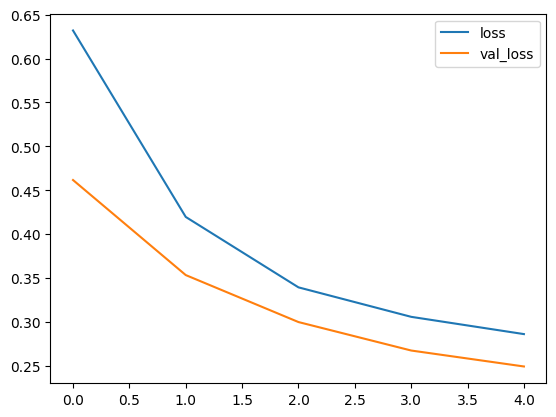

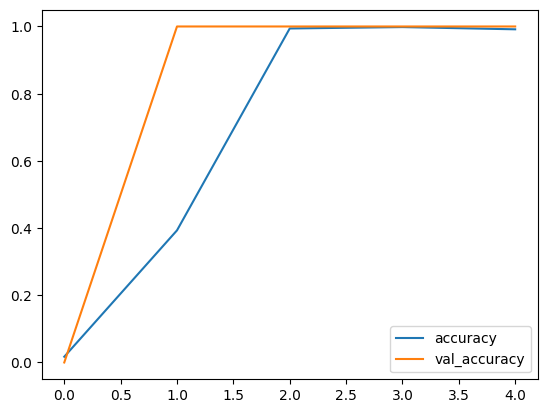

In [76]:
df = pd.DataFrame(history.history)
df.plot(y=['loss', 'val_loss'])
df.plot(y=['accuracy', 'val_accuracy'])

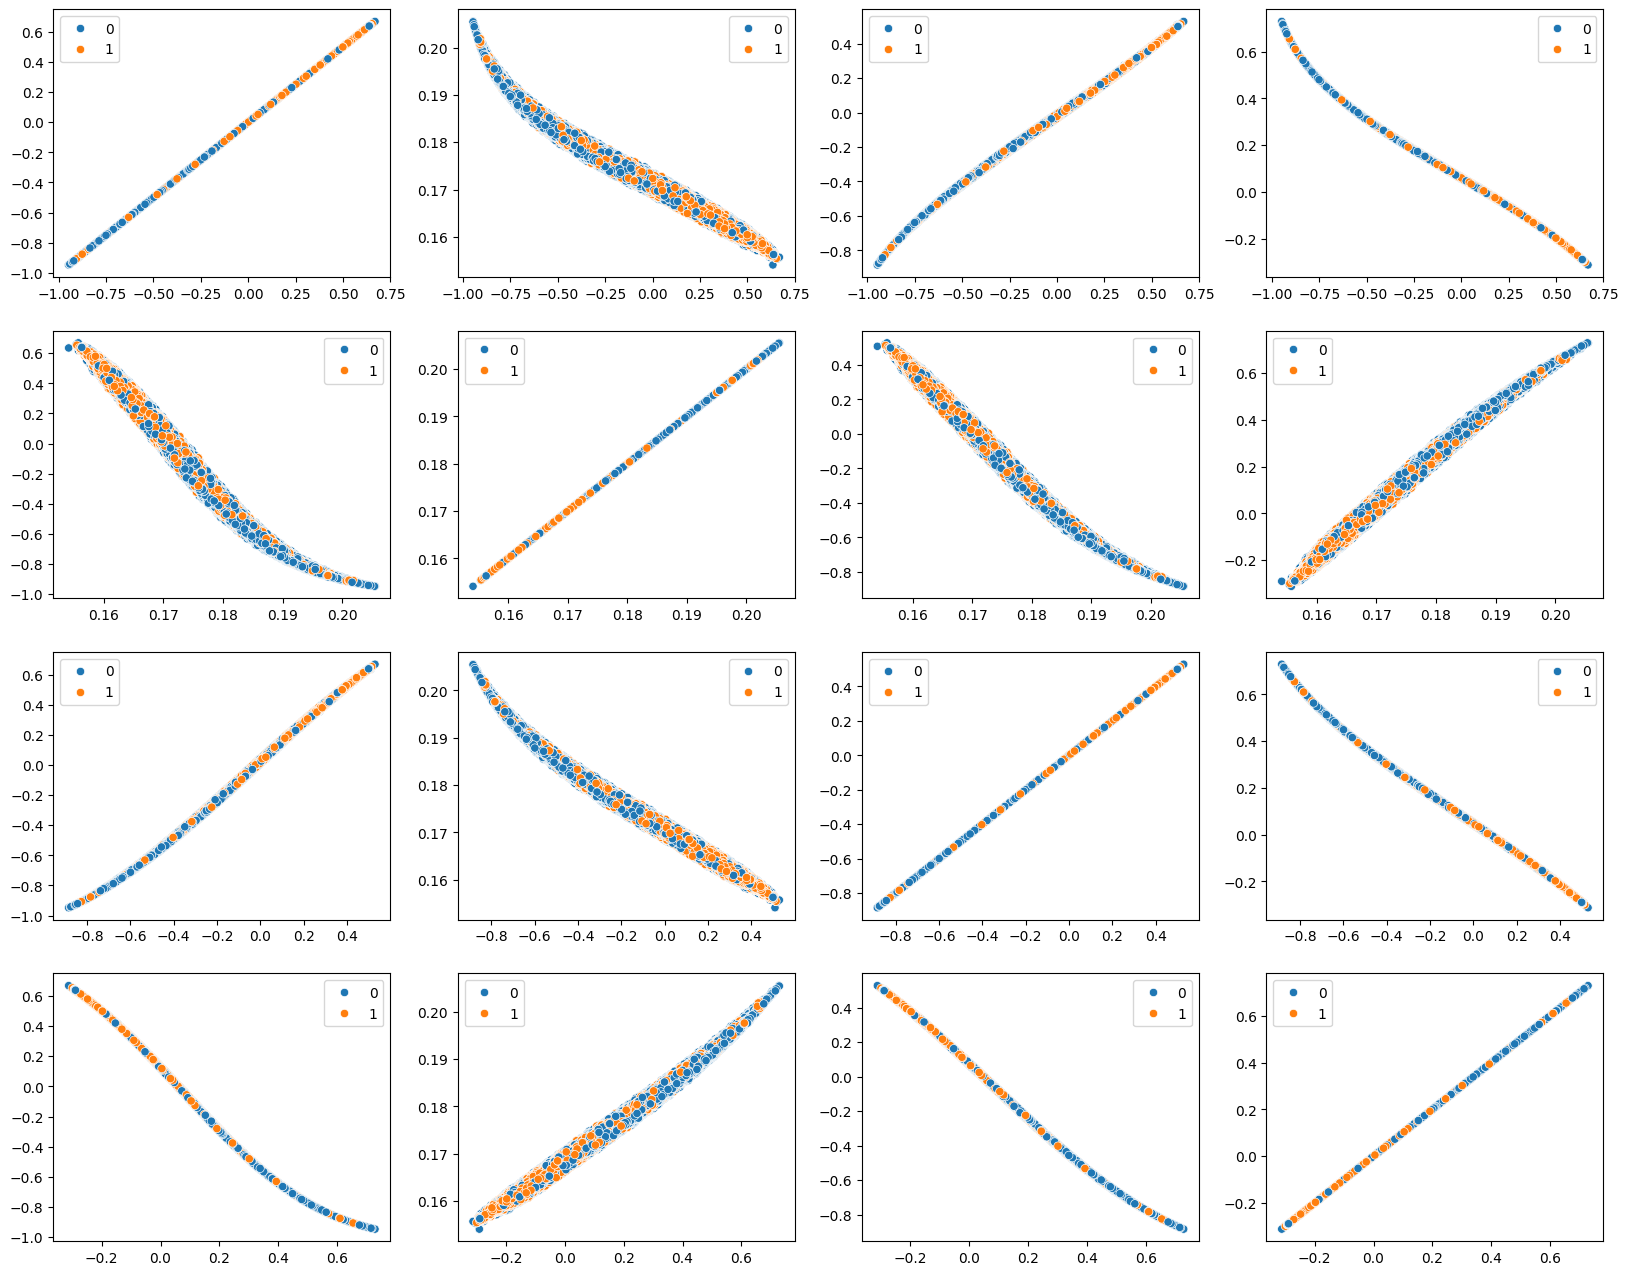

In [193]:
x_train_encoded = encoder(x_train)
encoded_train_ds = x_train_encoded.numpy()
fig ,axes = plt.subplots(4, 4, figsize=(20,16))
for idx in range(4):
    for jdx in range(4):
        sns.scatterplot(x=encoded_train_ds[:,idx], y=encoded_train_ds[:,jdx],  hue=transformed_train_ds['fraude'].to_numpy(), ax = axes[idx, jdx])


# Entrenamiento del modelo 2

In [7]:
@tf.function
def get_y_tilde(M_0:tf.constant, M_1:tf.constant, y):
    threshold = 0.25 * M_0 + M_1
    epsilon = tf.constant(1e-3, dtype=tf.float32)
    return epsilon+threshold - threshold * y

@tf.function
def nll_bernoulli_tilde(M_0:tf.constant, M_1:tf.constant, y, y_hat):
    y_casted = tf.expand_dims(tf.cast(y, dtype=tf.float32),-1)
    y_tilde = get_y_tilde(M_0, M_1, y_casted)
    #return -tf.reduce_mean(y_casted*tf.math.log(y_hat) +  (1-y_casted)*tf.math.log(1 - y_hat))
    return -tf.reduce_mean(#  0.25 * M_0 * (1-y_casted) * (1-y_hat)\
                           #- 0.25 * M_0 * (1-y_casted) *  (y_hat) \
                           #- M_1*y_casted * (1-y_hat)
        
        ( 0.25 * M_0 -(0.25*M_0 + M_1 )*y_casted )*(1-y_hat) -  0.25* M_0*(1-y_casted)*y_hat 
                           ) 

def monto_transform_inverse(monto):
    _monto_un_scaler = np.log(3000)
    monto_inv = np.expm1(monto*_monto_un_scaler)
    return tf.cast(tf.constant(monto_inv), dtype=tf.float32)
    

In [8]:
monto_borders = np.insert(np.insert(transformed_train_ds['monto'].quantile([0.2,0.4,0.6,0.8]).to_numpy(), 4,1.1),0,0)
brakets_filter = [(monto_borders[idx], monto_borders[idx+1]) for idx in range(len(monto_borders)-1)]
brakets_tilde = [(monto_transform_inverse(M_0),monto_transform_inverse(M_1)) for M_0,M_1 in brakets_filter]



In [9]:
def get_ds_for_braket(m_0, m_1, df_x, df_y):
    df_filter_braket = (m_0 <= df_x['monto']) & (df_x['monto'] <m_1)
    df_x['fraude']=df_y['fraude']
    x = df_x[df_filter_braket][numeric_X_cols].to_numpy()
    y = df_x[df_filter_braket]['fraude'].to_numpy()
    return x,y

In [10]:
Braket_train_data = [get_ds_for_braket(m_0, m_1, filled_ds_data_train, transformed_train_ds) for m_0, m_1 in brakets_filter]
Braket_test_data = [get_ds_for_braket(m_0, m_1, filled_ds_data_test, transformed_test_ds) for m_0, m_1 in brakets_filter]

In [11]:
def get_model_for_braket_idx(braket_idx, epochs = 10):
   Probability_of_fraud_v2_b0= Sequential([Dense(16, activation = 'relu',  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01), bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                    Dense(16, activation = 'tanh',  kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01), bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                    Dropout(0.5),
                                    
                                    Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01), bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)),
                                       ])
   
   metrics = [tf.metrics.BinaryCrossentropy(), 
         tf.metrics.Precision(name='precision'),
         tf.metrics.Recall(name='recall')]
   Probability_of_fraud_v2_b0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                              metrics = metrics,
                              loss= 'BinaryCrossentropy' # lambda y_true, y_pred: nll_bernoulli_tilde(brakets_tilde[braket_idx][0], brakets_tilde[braket_idx][1], y_true, y_pred) #'BinaryCrossentropy'
                                 )
   prob_func_hist_b0 = Probability_of_fraud_v2_b0.fit(Braket_train_data[braket_idx ][0], Braket_train_data[braket_idx ][1],
            batch_size=1024,
            epochs=epochs,
            shuffle=True,
            validation_data=Braket_test_data[braket_idx], validation_steps=1,
            verbose= 0,
            )
   print(tf.math.confusion_matrix( tf.math.round(Probability_of_fraud_v2_b0(Braket_test_data[braket_idx][0])) ,tf.constant( Braket_test_data[braket_idx][1]) ))
   return prob_func_hist_b0 , Probability_of_fraud_v2_b0

In [ ]:
tmp_prob_func_hist_b0 , tmp_Probability_of_fraud_v2_b0  =get_model_for_braket_idx(4, epochs = 50)

<Axes: >

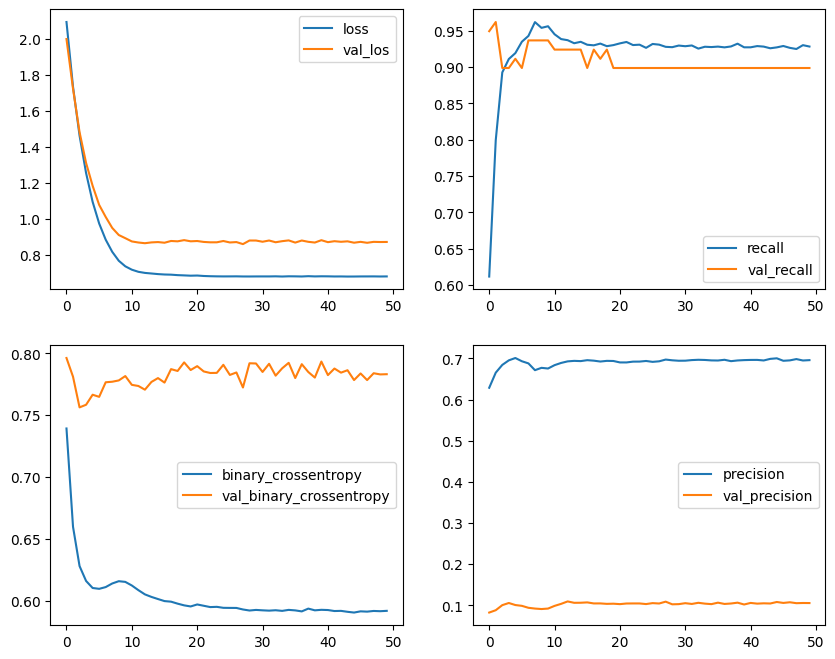

In [448]:
fig, ax =  plt.subplots(2,2,figsize=(10,8))
sns.lineplot(tmp_prob_func_hist_b0.history['loss'], ax = ax[0,0], label = 'loss')
sns.lineplot(tmp_prob_func_hist_b0.history['val_loss'], ax = ax[0,0], label = 'val_los')
sns.lineplot(tmp_prob_func_hist_b0.history['recall'], ax = ax[0,1], label = 'recall')
sns.lineplot(tmp_prob_func_hist_b0.history['val_recall'], ax = ax[0,1], label = 'val_recall')
sns.lineplot(tmp_prob_func_hist_b0.history['binary_crossentropy'], ax = ax[1,0], label = 'binary_crossentropy')
sns.lineplot(tmp_prob_func_hist_b0.history['val_binary_crossentropy'], ax = ax[1,0], label = 'val_binary_crossentropy')
sns.lineplot(tmp_prob_func_hist_b0.history['precision'], ax = ax[1,1], label = 'precision')
sns.lineplot(tmp_prob_func_hist_b0.history['val_precision'], ax = ax[1,1], label = 'val_precision')

In [12]:
modelos = [get_model_for_braket_idx(braket_idx) for braket_idx in range(len(brakets_filter))]

tf.Tensor(
[[1455   51]
 [ 140   13]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1392   60]
 [ 202   16]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1185   27]
 [ 284   40]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1106   25]
 [ 271   51]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[302   6]
 [788  86]], shape=(2, 2), dtype=int32)


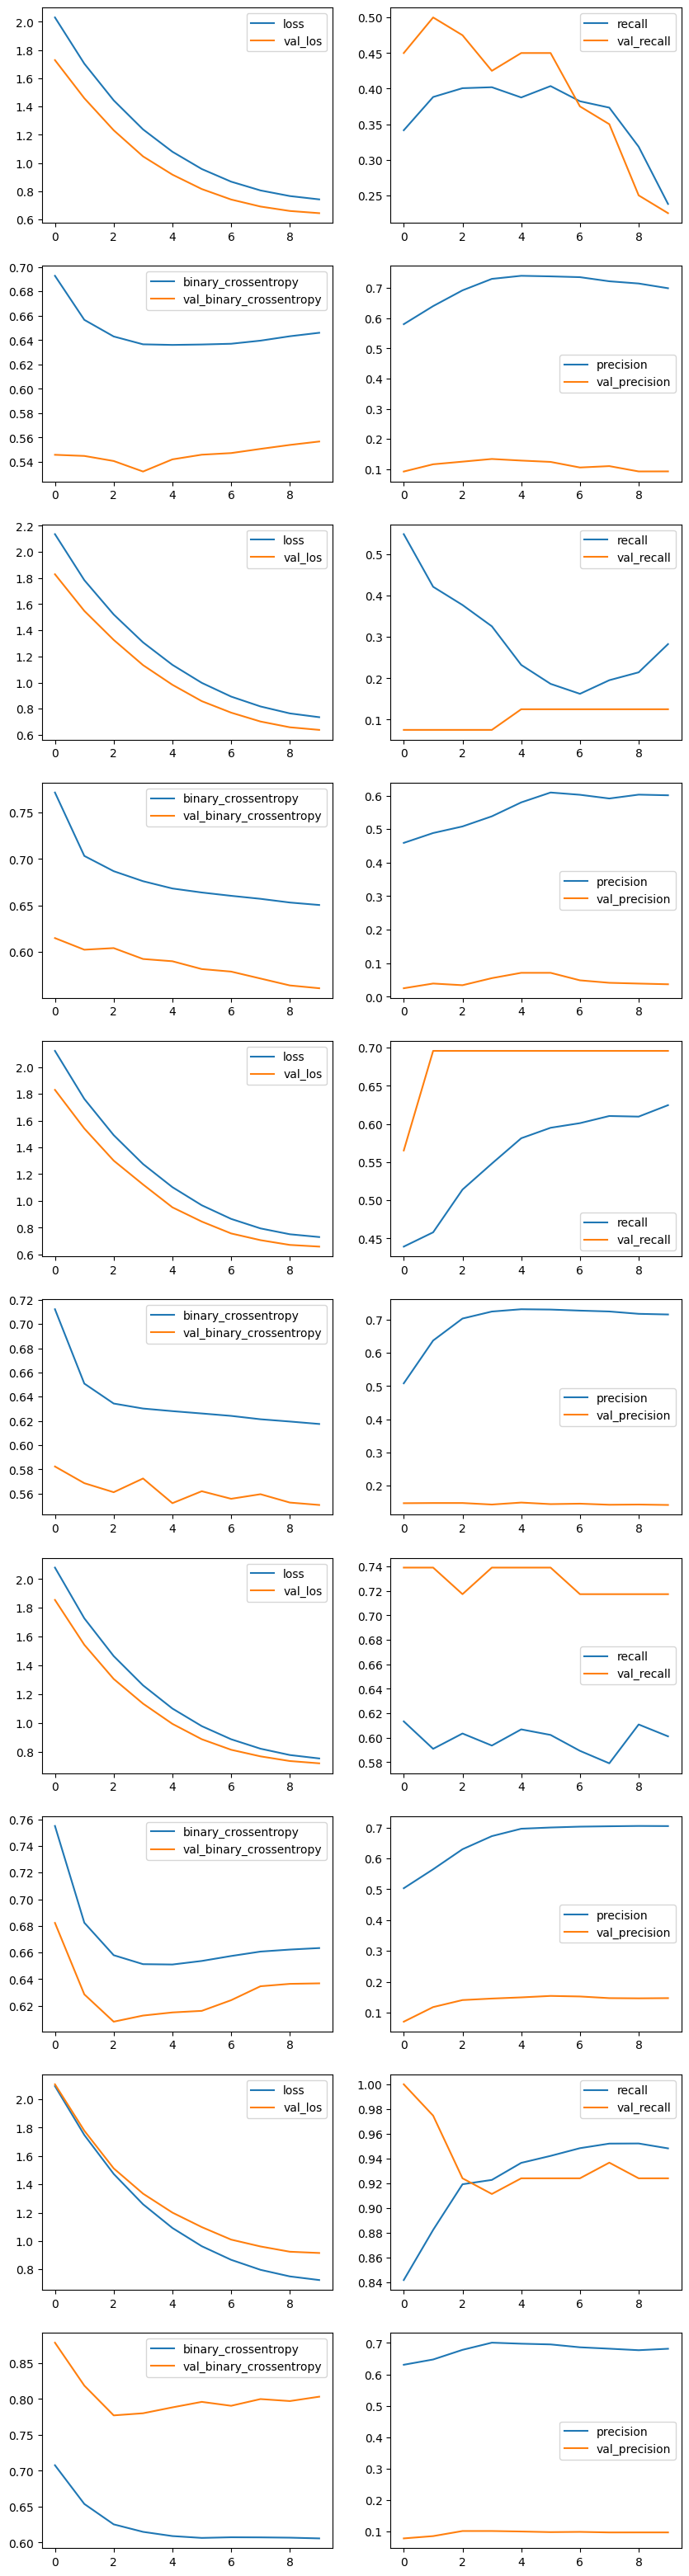

In [13]:
fig, ax =  plt.subplots(10,2,figsize=(10,8*5))
for idx, (historial, modelo) in enumerate(modelos):
    sns.lineplot(historial.history['loss'], ax = ax[2*idx,0], label = 'loss')
    sns.lineplot(historial.history['val_loss'], ax = ax[2*idx,0], label = 'val_los')
    sns.lineplot(historial.history['recall'], ax = ax[2*idx,1], label = 'recall')
    sns.lineplot(historial.history['val_recall'], ax = ax[2*idx,1], label = 'val_recall')
    sns.lineplot(historial.history['binary_crossentropy'], ax = ax[2*idx+1,0], label = 'binary_crossentropy')
    sns.lineplot(historial.history['val_binary_crossentropy'], ax = ax[2*idx+1,0], label = 'val_binary_crossentropy')
    sns.lineplot(historial.history['precision'], ax = ax[2*idx+1,1], label = 'precision')
    sns.lineplot(historial.history['val_precision'], ax = ax[2*idx+1,1], label = 'val_precision')


In [14]:
def get_predictions(models,brakets_filter, x ):
    index_monto = 13
    rango_monto = [tf.expand_dims(
    tf.constant(
        1*((m_0<= x[:,13]) * (x[:,13]<= m_1))
        , dtype=tf.float32)
        ,-1)for m_0, m_1 in brakets_filter]
    predicciones =tf.stack( [rango_i * modelo_i[1](x) for rango_i, modelo_i in zip(rango_monto, models) ] , axis = 1)

    return tf.math.reduce_sum(predicciones, axis=1)
def get_model_predictions(x):
    return get_predictions(modelos, brakets_filter, x).numpy()


In [15]:
y_hat_dev = get_predictions(modelos, brakets_filter, filled_ds_data_dev[numeric_X_cols].to_numpy())
y_dev =tf.constant(transformed_dev_ds['fraude'].to_numpy(), dtype= tf.float32)
tf.math.confusion_matrix( tf.math.round(y_hat_dev) ,y_dev )

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5479,  180],
       [1646,  195]])>

In [28]:
195/(198+180)

0.5158730158730159

In [29]:
195/(195+1646)

0.10592069527430745

In [19]:
import shap
x_train=filled_ds_data_train[numeric_X_cols].to_numpy()
x_dev=filled_ds_data_dev[numeric_X_cols].to_numpy()
explainer = shap.KernelExplainer(get_model_predictions,shap.kmeans(x_train, 10))


In [ ]:
shap_values = explainer.shap_values(x_dev,nsamples=50)


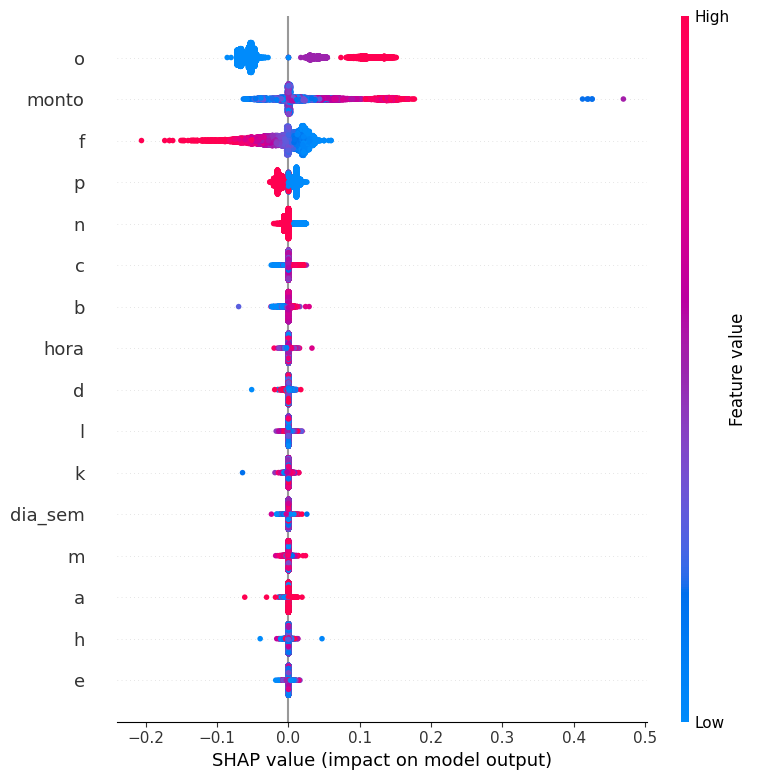

In [27]:
shap.summary_plot(np.squeeze(shap_values,-1),x_dev,feature_names=numeric_X_cols)

# Respuestas finales

## 1. 
Entrene un algoritmo con el fin de predecir el fraude sabiendo que por cada
transacción el porcentaje de ganancia es de un 25%, y por cada fraude aprobado
se pierde el 100% del dinero de la transacción. Realizar un análisis y determinar
un modelo que permita maximizar la ganancia de la empresa.

Durante el el desarrollo del problema he visto diferentes formas de implementar la función que se quiere máximizar. 
El hecho que esta función esté atada al monto implica que la función de pérdida ya no necesariamente es una función convexa. 
Dos implementaciones posibles que me llevaron a esta conclusión son las siguientes:
$$\left(0.25 - 1.25 y -0.50 \hat{y}+1.50 y \hat{y}  \right) * monto$$
$$R=\left(\Pi_i \left(1 + 0.25 f (1-y) \right)^{1-\hat{y}}\left(1 - 0.25 f (1-y) \right)^{\hat{y}}\left( 1- f y\right)^{1-\hat{y}}\left( 1 + 0 f y  \right)^{\hat{y}}   \right)^{1/n}$$
Ambas funciones dicen lo mismo visto desde perspectivas distintas, la primera es el ingreso, la segunda es el ingreso porcentual.
La razón de esta conclusión es que si se compara para el mismo modelo el camino de descenso de alguna de estas funciones:

![funcion descenso 2](noisy_gradient_descent.png)

con respecto al "negative log likelihood" de una distribución de bernoulli:

![funcion descenso 2](noisy_gradient_descent_2.png)

es claro que en la segunda hay un descenso. Ahora bien, uno podría pensar que por el hecho que el eje "y" de la primera el orden de magnitud es pequeño, entonces, es porque la función ya convergió al mínimo. Pero, cabe anotar que el orden de magnitud de la función arriba llamada $R$ es bien pequeño, dado que f, es pequeño.

Como el objetivo es conseguir una función que maximice la ganancia de la compañía, es razonable usar proxies de la función de tal manera que maximizar estas sea equivalente a maximizar la función objetivo. Suponga que el precio de venta $M$ de algún item está acotado
entre $M_0\leq M\leq M_1$ entonces la siguiente desigualdad es cierta:
$$(0.25(1-y) M_0 -M_1 y)(1-\hat{y})\leq  (0.25(1-y) M -M y)(1-\hat{y})$$

El lado izquierdo de la desigualdad es equivalente a:
 $$ (0.25M_0 -(0.25 M_0 + M_1)y)(1-\hat{y})$$

 Ahora, como esta última función no depende del monto, $M_0$ y $M_1$ son constantes para la función de descenso y sólo depende de $y$ y $\hat{y}$.
 La variable $\tilde{y}=M_1+ 0.25M_0 -(0.25 M_0 + M_1)y$ se usará en la función de descenso en la parte que respecta del nll.

## 2. Realizar un pequeño informe de la solución propuesta:

* Hipótesis: El dataset contiene los datos de un periodo de tiempo en Mercado Libre y se deben poder identificar algunos tipos de metodologías de fraude por parte de los atacantes.
La estrategia para abordar el problema será la siguiente: 
    * Análizar los datos a una sóla variable y su relación con el fraude, las distribuciones de cada una de las variables y en lo posible desanonimizar algunas de ellas para mejorar el entendimiento de estas de acuerdo a la naturaleza del negocio.
    * Hacer transformaciones del conjunto de datos de acuerdo al análisis previo
    * Sin un orden particular, buscar estrategias no supervisadas para segmentar los datos y reducir la dimensión. De tal manera que podamos tener transacciones similares y para cada uno de estos conjuntos entrenar un modelo que minimice la función de pérdida descrita en el punto anterior.
    * crear un pipeline con lo desarrollado en el punto anterior para el despligue del modelo. 
* Análisis y transformaciones del dataset:
    * la columna g representa el país de compra o venta del producto, por tanto es extraño que haya NA's. Por tanto, al ser categorica esta columna, los NA, se reemplazaran como otra categoría ('UNK').
    * la columna j representa el producto comprado, o su categoría, dar detalles....
    * las columnas o,p representan respuestas a preguntas de si, o no. Los vacíos de la columna o se reemplazaran con "no se"
    * las columnas numéricas que tienen NA's es claro que hay tres emparejamientos, a saber, las columnas  d y m, b y c y, f y l. Por tanto, las estrategia de relleno debe estar vinculada.
        * Se usará el promedio de los k - vecinos más cercanos para rellenar los datos de tal manera que los datos se rellenen de forma semejante.
    * el orden de magnitud de las columnas c,e,f, m debe ser escalado, se hará usando el logaritmo, a saber $log1p( x) /log( cota)$, la cota no será el máximo, si no, el orden de magnitud para evitar sobre ajuste muestral.
    * no hay ninguna de las variables que su distribución cambie significativamente para aquellos casos donde hubo fraude, ni para las temporales, ni para las numéricas. 
    * b y log(c) parece como si tuviesen una distribución similar salvo en las colas. aunque no tienen mucha correlación 
    * de los violines la única variable que parece tener una distribución clara es k, a saber uniforme.
    * La mayoría de los datos de la columna e son pequeños una vez reescalados con log1p(), pero mantiene altos niveles de ruido, por eso se acotará a 1.
        * esta es una variable que se debería analizar con el dueño de la información para ver el tipo de tratamiento que debería tener. ¿ son más importantes los outliers?, ¿es más importante la masa de información?, se debería asociar a esta variable alguna variable categoríca que represente el orden de magnitud de la variable y se ponga atención sobre ese segmento. En conclusión, el tratamiento que se le da en este proyecto a esta variable no necesariamente es el más adecuado
    * De la fecha se extraerá el día de la semana y la hora de la operación. 
        * Al comparar los histogramas de todas las transacciones contra aquellos donde hubo fraude, se puede observar que tienen una distribución similar. 
        * No es claro del data set si estos datos son utc, o hora local del país de origen, o hora local del servidor de Mercado Libre, aun así, se tratarán como si fuera hora local, en caso que no fuesen se deberían transformar estas fechas en hora local.
* Modelos Utilizados
    * Para reducir las dimensiones se probó con PCA  a 8 dimensiones
    * Autoencoders a 8, 6 y 4 dimensiones. Observando que el último caso tiene buen performance y generaliza muy bien sobre el test set, se toma este.
    * Se probó como estrategia de segmentación k - medias, De los datos no se observa que se creen segmentos claramente bien definidos. Se usa la Sillueta para validar la calidad de la segmentación y con PCA o sin reducir las dimensiones, esta no supera 0.4. Al usar los auto encoders a 4 dimensiones se observa que los datos quedan en una sola "nube de datos", por tanto se descarta el uso de la segmentación como primer paso para la clasificación.
    * Se entrena una red neuronal simple
    * Dado el bueno comportamiento de los auto encoders se procede a crear un ciclo de entrenamiento con la función de pérdida descrita en la primera parte del punto anterior.
        * Como se mencionó previamente las diferentes arquitecturas para redes neuronales basadas en las funciones de pérdida iniciales no tienen buenos resultados y se descarta ésta aproximación a la función a maximizar
        * Se prueba ahora el modelo en su versión más simple, es decir, el equivalente a una regresión logistica con función de pérdida "binary cross entropy" y se observa que este modelo tiene una Presición aceptable (0.65) y un recall mediocre (0.14).
        En consecuencia se retoma el análisis de la función de pérdida y se concluye que es mejor tomar una aproximación "piecewise linear " a la función objetivo dado los análisis hechos previamente.
        Este modelo tiene mejores resultados que lo observado anteriormente, pero se puede ver una clara discrepancia en la predicción al habaer muchos más falsos positivos en test versus entrenamiento. Esto quiere decir que hay un alto grado de memorización a los fraudes observados en el conjunto de entrenamiento. 
* Evaluación
    * La presición y el recall en el dev set se ven inferiores a las del test set, por tanto es claro que el modelo no generaliza bien y por tanto no se podría desplegar en producción. De la gráfica de Shap se puede ver claramente que las variables que más impactan el modelo son o, monto y f. Es fácil esperar que la variable monto tenga mucho peso en la predicción dado que gran parte del ciclo de entrenamiento está basado en su magnitud. Cabría preguntar al equipo dueño de los datos el origen de la variable o y su significado dado que los que responden si, son más propensos a hacer fraude.  
* Conclusión
    * Este es un problema que requiere muchas más iteraciones sobre sus posibles soluciones. Debido al buen performance del auto encoder gasté bastante tiempo iterando sobre arquitecturas de redes neuronales y  dejé de lado otras posibles aproximaciones. En siguientes iteraciones antes de aumentar el set de datos, procedería primero a agregar las variables de categoría y país que no se tuvieron en cuenta debido a que en el prototipado estaba buscando iteraciones rápidas sobre el modelo, y estas variables categoricas al codificarlas en algo como un "one hot vector" tendríamos modelos más grandes y lentos para su prototipado, de tal manera que no se puede hacer rápidas iteraciones sobre las distintas arquitecturas. 
    * Debido a que el modelo tiene un alto grado de memorización es necesario cambiar la forma de balanceo de los fraudes. Lo más razonable sería usar algo como SMOTE, pero esto para una iteración en la que se pueda dejar corriendo el modelo desatendido por varias horas dado lo lento de esta estrategia. 



## 3. ¿Qué pasos puedo seguir para intentar asegurar que la performance del modelo en laboratorio será similar a la de producción?

* Como se notó el dev set se usa para medir la capacidad de generalización del modelo, es decir, medir los resultados en un dataset que viene de la misma distribución, pero no ha sido usado para entrenar el modelo, como el test set que se usa para conseguir "Early stopping" o validar los datos a medida que se entrena el modelo. Por tanto, es razonable esperar que eso permita evaluar la capacidad de predicción en producción.
* Asegurar que la data usada para entrenar el modelo venga de la misma distribución de la data de producción.
* Procurar que la data usada para entrenar sea reciente, de tal manera que capture nuevas estrategias de fraude que hayan podido implementar los criminales.
* Entrenar el modelo con datos que correspondan a un intervalo de tiempo más largo. 


## 4. Suponiendo que la performance predictiva en producción es muy diferente a la esperada, ¿Cuáles cree que son las causas más probables?

Usualmente las razones para que un modelo no generalice lo suficientemente bien, es porque las distribuciones de entrenamiento y producción son distintas. En este caso particular qué quiere decir, los métodos para hacer fraude pueden haber cambiado de 2020 a la fecha actual, por tanto a pesar que los datos son capturados de la misma forma las condiciones en el mundo han cambiado ligeramente. Ya sea por factores macroeconómicos o por nuevas estrategias de fraude que hayan descubierto. Por tanto la primera solución como se mencionó en el punto anterior es usar más datos, y procurar que sean recientes. Otra razón por la cual el modelo no generaliza bien es porque hay sobre ajuste en el entrenamiento, por tanto, se deberá mejorar la regularización del modelo o quitarle un poco de paciencia al "early stoping" de tal manera que el entrenamiento se detenga antes y no haya sobre ajuste.


## 5. ¿Qué pasos debería seguir para poner el nuevo modelo en producción?

Los pasos a seguir son un esquema general de cómo pasar del laboratorio producción a producción y están atados a diferentes tecnologías que dependen de la infraestructura propia de Mercado Libre y aquellos sistemas que tenga implementados para la orquestación de soluciones en la nube. Los pasos siguientes son generales y agnosticos del sistema. 
* El primer paso es crear un paquete con las funciones y objetos relevantes para este modelo.
* El siguiente paso, depende de la infraestructura y servicios internos de la compañía. Esto es crear una función que reciba los datos de producción, ya sea en un json, o algún sistema de menor latencia como apache Arrrow, transforme los datos recibidos ejecutando el modelo y envíe la respuesta de aprobación o no al sistema transaccional, y otras salidas relevantes, como logs, o almacenamiento de resultados en alguna Base de datos.
* De acuerdo a la infraestructura será desplegado como una cloud function o en algún tipo de ambiente "contained" eg. Kubernetes. Por tanto se deberá crear el paquete o la imagen del contenedor del programa.
* Se deberá seleccionar algún tipo de "template" de en qué máquina será ejecutado, ejemplo un N2 con X gigas de Ram y una Nvidia T4, de acuerdo a los requerimientos de tiempo y presupuestales.
* El modelo anterior debería ser probado en un ambiente de pruebas y observar que los resultados y tiempos de ejecución sean los esperados, En caso negativo tocará volver a alguno de los pasos anteriores y ajustar dicho paso. 
 

# Otras pruebas

### K - Medias

In [ ]:



def get_k_means(n, X ):
    centroid, label, inertia = k_means(X = X, n_clusters=n, random_state=seed, n_init='auto')
    sample_silhouette_values = silhouette_samples(X,  label)
    obs_per_cluster = [ len(sample_silhouette_values[label == idx]) for idx in range(n)]
    silhouette_per_cluster = [ np.mean(sample_silhouette_values[label == idx]) for idx in range(n)]
    silhouette_Score = np.mean(sample_silhouette_values)
    print(f'finished {n} means' )
    return silhouette_Score, silhouette_per_cluster, obs_per_cluster, centroid, label, inertia

#k_means_path_raw_data = {n:get_k_means(n,100* filled_ds_data_train[numeric_X_cols].to_numpy() ) for n in tqdm(range(2,10))}
k_means_path_encoded_data = {n:get_k_means(n,100* x_train_encoded ) for n in tqdm(range(2,10))}
fig, axes = plt.subplots(1, figsize=(5,4))
#sns.lineplot(x=range(2,10), y=[np.min(v[1]) for _,v in k_means_path_raw_data.items()], ax= axes, label = 'min Silhouette Raw')
#sns.lineplot(x=range(2,10), y=[v[0] for _,v in k_means_path_raw_data.items()], ax= axes, label = 'total Silhouette Raw')
sns.lineplot(x=range(2,5), y=[np.min(v[1]) for _,v in k_means_path_encoded_data.items()], ax= axes, label = 'min Silhouette encoded')
sns.lineplot(x=range(2,5), y=[v[0] for _,v in k_means_path_encoded_data.items()], ax= axes, label = 'total Silhouette encoded')

### Redes Neuronales v1

In [ ]:
class FraudModel(Model):
    
    def __init__(self, encoder, encoder_dim , dropout_rate= 0.5,  **kwargs):
        super(FraudModel, self ).__init__(**kwargs)

        self._index_monto = 13
        self._monto_un_scaler = tf.cast(tf.constant(tf.math.log(3000.0)), dtype=tf.float32)
        self._monto_0_25 = tf.constant(0.25, dtype=tf.float32)
        self._monto_1_25 = tf.constant(1.25, dtype=tf.float32)
        self.encoder = encoder
        encoder.trainable = False
        self._dense_1 = Dense(encoder_dim, activation = 'sigmoid',  kernel_regularizer=regularizers.l2(0.001))
        self._dropout_1 = Dropout(dropout_rate)
        self._dense_2 = Dense(encoder_dim, activation = 'sigmoid',  kernel_regularizer=regularizers.l2(0.001))
        self._dropout_2 = Dropout(dropout_rate)
        self._dense_3 = Dense(2, activation = 'sigmoid',  kernel_regularizer=regularizers.l2(0.001))
        self._dropout_3 = Dropout(dropout_rate)
        self._out_layer = Dense(1, activation = 'sigmoid',  kernel_regularizer=regularizers.l2(0.001))

    @tf.function
    def call(self, inputs, training  = True):

        x = self.encoder (inputs)
        x = self._dense_1 (x)
        if training:
            x = self._dropout_1(x)
        x = self._dense_2 (x)
        if training:
            x = self._dropout_2(x)
        x = self._dense_3 (x)
        if training:
            x = self._dropout_3(x)
        y_hat = self._out_layer (x)

        monto =tf.expand_dims(  tf.math.expm1 ( inputs[:,self._index_monto]*self._monto_un_scaler), 1)
        factor_perdida = self._monto_0_25 - self._monto_1_25 * y_hat
        exp_revenue = tf.math.multiply(factor_perdida, monto )
        return y_hat, exp_revenue, monto


        

Considere $i$ la $i$-ésima observación, $f_i= monto_i/\sum{monto_j}$,  la observación si hubo fraude o no $y_i$ y, su respectiva estimación $\hat{y}_i$.
Por simplicidad omitiendo el índice $i$, porcentualmente el retorno de esa transacción se puede expresar el siguiente valor:

$\left(1 + 0.25 f (1-y) \right)^{1-\hat{y}}\left(1 - 0.25 f (1-y) \right)^{\hat{y}}\left( 1- f y\right)^{1-\hat{y}}\left( 1 + 0 f y  \right)^{\hat{y}}$

Es fácil ver que los cuatro componentes del producto representan la ganancia esperada en cada una de las posibilidades de las combinaciones de $y$  e $\hat{y}$.
Note además que para cualquier combinación de estas dos variables sólo uno de los términos del producto se activa. 
La construcción de este término viende pensar que en un falso positivo se pierde la oportunidad de una venta, por tanto $-0.25f$, en un falso negativo, claramente se pierde el $100$%, y cuando la predicción es correcta, se gana el $25$% en caso de no ser fraude, o no se pierde nada de lo contrario.
Para un conjunto de operaciones el retorno promedio será:

$R=\left(\Pi_i \left(1 + 0.25 f (1-y) \right)^{1-\hat{y}}\left(1 - 0.25 f (1-y) \right)^{\hat{y}}\left( 1- f y\right)^{1-\hat{y}}\left( 1 + 0 f y  \right)^{\hat{y}}   \right)^{1/n}$

Por tanto es razonable  maximizar el retorno descrito anteriormente. Que es equivalente a maximizar su logartimo:

$ln (R) = 1/n \Sigma (1-\hat{y}) ln \left(1 + 0.25 f (1-y) \right) +(1-\hat{y}) ln \left( 1- f y\right) + \hat{y}\left(1 - 0.25 f (1-y) \right) $

Ahora, esta función es muy similar al "negative log likelihood" de una distribución de bernoulli. 

Por tanto, la función de pérdida será el negativo de la función descrita anteriormente.

* nota, los signos del segundo y tercer términos están dentro de la constante.

In [127]:
@tf.function
def nExpected_Revenue(y, y_hat, monto):
    
    y_hat_2 = tf.round(y_hat)
    y = tf.cast(y, tf.float32)
    const_0_25 = tf.constant(0.25, dtype=tf.float32)
    const_1 = tf.constant(1, dtype=tf.float32)
    monto_total = 50 * tf.math.reduce_mean(monto)
    f = monto / monto_total

    primer_sumando = (const_1-y_hat_2) * tf.math.log1p(const_0_25 * f * (const_1 - y)) 
    segundo_sumando = (const_1-y_hat_2) * tf.math.log(1- f *  y)
    tercer_sumando = y_hat_2 * tf.math.log1p( const_0_25 * f * (y - const_1 )) 

    ln_R_ = tf.math.reduce_mean(primer_sumando + segundo_sumando + tercer_sumando) 

    return - ln_R_


In [190]:
Probability_of_fraud = FraudModel(encoder,4,0.5)


In [93]:
losss_fn2= tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
   
    reduction='sum_over_batch_size',
    name='binary_crossentropy'
)

In [191]:
x_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
x_train_ds = x_train_ds.batch(1024)
x_test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
x_test_ds = x_test_ds.batch(1024)
metrics = [tf.metrics.BinaryCrossentropy(),  
      tf.metrics.MeanSquaredError(),
      tf.metrics.TruePositives(name = 'true_Positives'),
      tf.metrics.FalsePositives(name = 'false_Positives'),
      tf.metrics.TrueNegatives(name = 'true_Negatives'),
      tf.metrics.FalseNegatives(name = 'false_Negatives'),
      tf.metrics.BinaryAccuracy(),
      tf.metrics.Precision(name='precision'),
      tf.metrics.Recall(name='recall')]
metrics_history = {metric.name:[] for metric in metrics}
val_metrics_history = {'val_'+metric.name:[] for metric in metrics}
num_epochs = 5
mini_batch_loss = []
epoch_loss = []
val_epoch_loss = []
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
for epoch in tqdm(range(num_epochs)): 
    #todo loggin compatible with tqdm
    for batch_idx, (x_batch, y_batch) in enumerate(x_train_ds):
        with tf.GradientTape() as tape: 
            y_hat, _ , monto = Probability_of_fraud(x_batch, training = True)
            #loss = nExpected_Revenue(y_batch, y_hat, monto)
            loss = losss_fn2(y_batch, y_hat)
            gradients = tape.gradient(loss, Probability_of_fraud.trainable_variables)
            optimizer.apply_gradients(zip(gradients, Probability_of_fraud.trainable_variables))
        mini_batch_loss.append(loss.numpy())
        for metric in metrics:
            metric.update_state(tf.round(y_hat), y_batch)
    epoch_loss.append(loss.numpy())        
    for metric in metrics:
        metrics_history[metric.name].append(metric.result().numpy())
        metric.reset_state()
    
    for batch_idx, (x_batch, y_batch) in enumerate(x_test_ds): 
        y_hat, _ , monto = Probability_of_fraud(x_batch, training = False)
        loss = nExpected_Revenue(y_batch, y_hat, monto)
        for metric in metrics:
            metric.update_state(tf.round(y_hat), y_batch)
    val_epoch_loss.append(loss.numpy())
    for metric in metrics:
        val_metrics_history['val_'+metric.name].append(metric.result().numpy())
        metric.reset_state()
    ##TODO save_checkpoints
    ##TODO analize early stoping
    #TODO Other callbacks?


100%|██████████| 5/5 [00:58<00:00, 11.66s/it]


<Axes: >

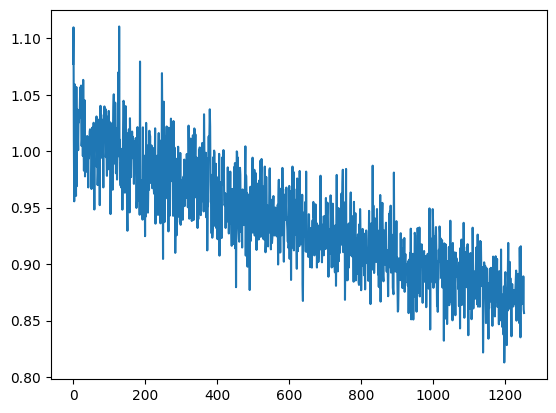

In [192]:
sns.lineplot(mini_batch_loss)

In [137]:
metrics_history

{'binary_crossentropy': [7.6874733,
  7.6802664,
  7.6770406,
  7.6862526,
  7.6783013],
 'mean_squared_error': [0.499864,
  0.49939692,
  0.4991859,
  0.4997873,
  0.49926874],
 'true_Positives': [64188.0, 64160.0, 64244.0, 64074.0, 64211.0],
 'false_Positives': [64062.0, 64090.0, 64006.0, 64176.0, 64039.0],
 'true_Negatives': [64098.0, 64223.0, 64210.0, 64216.0, 64228.0],
 'false_Negatives': [64152.0, 64027.0, 64040.0, 64034.0, 64022.0],
 'binary_accuracy': [0.50014037, 0.5005185, 0.5007953, 0.5001559, 0.50073683],
 'precision': [0.5004912, 0.5002729, 0.50092787, 0.49960235, 0.50067055],
 'recall': [0.50014025, 0.5005188, 0.5007951, 0.5001561, 0.50073695]}

In [138]:
tf.math.confusion_matrix( tf.math.round(Probability_of_fraud(x_train)[0]) ,tf.constant( y_train) )

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[     0,      0],
       [128250, 128250]])>

In [119]:
tf.math.confusion_matrix( tf.math.round(Probability_of_fraud(x_test)[0]) ,tf.constant( y_test) )

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[   0,    0],
       [7125,  375]])>

In [182]:
hidden_dims = 4
encoder.trainable = False
Probability_of_fraud_2 = Sequential([#Dense(16, activation = 'tanh',  kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                   #Dense(16, activation = 'tanh',  kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                   #Dropout(0.5),
                                   #Dense(13, activation = 'tanh',  kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                   #Dense(13, activation = 'tanh',  kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                   #Dropout(0.5),
                                   #Dense(10, activation = 'tanh',  kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                   #Dense(10, activation = 'tanh',  kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                   #Dropout(0.5),
                                   #Dense(4, activation = 'tanh',  kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                   #Dense(4, activation = 'tanh',  kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                   #Dropout(0.5),
                                   Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
                                      ])
Probability_of_fraud_2(x_train)
Probability_of_fraud_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (256500, 1)               17        
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [85]:
positive = np.sum(y_train)
total = len(y_train)
negative = total- positive

w_0 = 0.5 * total/negative
w_1 = 0.5 * total/positive
print(f'{positive} + {negative} = {total}')
print(f'w_0 = {w_0} w_1 = {w_1}')

128250 + 128250 = 256500
w_0 = 1.0 w_1 = 1.0


Epoch 1/10
251/251 [==============================] - 2s 6ms/step - loss: 0.7601 - binary_crossentropy: 0.7577 - precision: 0.4504 - recall: 0.2263 - val_loss: 0.6255 - val_binary_crossentropy: 0.6233 - val_precision: 0.0685 - val_recall: 0.5208
Epoch 2/10
251/251 [==============================] - 1s 5ms/step - loss: 0.6750 - binary_crossentropy: 0.6729 - precision: 0.5937 - recall: 0.4814 - val_loss: 0.5988 - val_binary_crossentropy: 0.5967 - val_precision: 0.0863 - val_recall: 0.6042
Epoch 3/10
251/251 [==============================] - 1s 5ms/step - loss: 0.6292 - binary_crossentropy: 0.6269 - precision: 0.6653 - recall: 0.6349 - val_loss: 0.5725 - val_binary_crossentropy: 0.5701 - val_precision: 0.0961 - val_recall: 0.6667
Epoch 4/10
251/251 [==============================] - 1s 5ms/step - loss: 0.6012 - binary_crossentropy: 0.5986 - precision: 0.6871 - recall: 0.6830 - val_loss: 0.5714 - val_binary_crossentropy: 0.5686 - val_precision: 0.1098 - val_recall: 0.7708
Epoch 5/10
251/2

<Axes: >

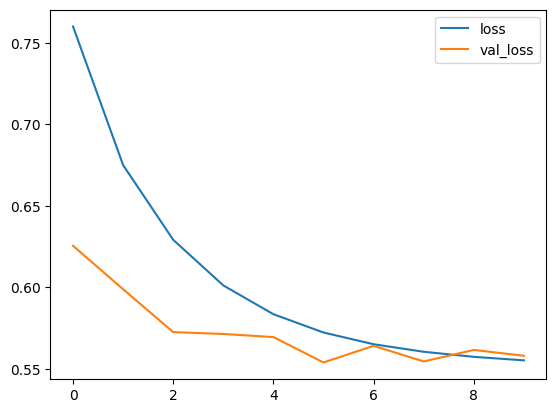

In [183]:


metrics = [tf.metrics.BinaryCrossentropy(),  
      #tf.metrics.MeanSquaredError(),
      #tf.metrics.TruePositives(name = 'true_Positives'),
      #tf.metrics.FalsePositives(name = 'false_Positives'),
      #tf.metrics.TrueNegatives(name = 'true_Negatives'),
      #tf.metrics.FalseNegatives(name = 'false_Negatives'),
      #tf.metrics.BinaryAccuracy(),
      tf.metrics.Precision(name='precision'),
      tf.metrics.Recall(name='recall')]
Probability_of_fraud_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                             metrics = metrics,
                             loss= 'BinaryCrossentropy')

prob_func_hist = Probability_of_fraud_2.fit(x_train, y_train,
          batch_size=1024,
          epochs=10,
          shuffle=True,
          validation_data=(x_test,y_test), validation_steps=1,
          class_weight={0:w_0,1:w_1})
df_prob_func_hist = pd.DataFrame(prob_func_hist.history)
df_prob_func_hist.plot(y=['loss', 'val_loss'])

In [184]:
tf.math.confusion_matrix( tf.math.round(Probability_of_fraud_2(x_test)) ,tf.constant( y_test) )

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5181,   91],
       [1944,  284]])>